# 反向传播算法实战

我们将实现一个 `4` 层的全连接网络，来完成二分类任务。网络输入节点数为 `2`，隐藏 层的节点数设计为：`25、50`和`25`，输出层两个节点，分别表示属于类别 `1` 的概率和类别 `2` 的概率，如下图所示。这里并没有采用 `Softmax` 函数将网络输出概率值之和进行约束， 而是直接利用均方误差函数计算与 `One-hot` 编码的真实标签之间的误差，所有的网络激活 函数全部采用 `Sigmoid` 函数，这些设计都是为了能直接利用我们的梯度传播公式。 

![](https://i.postimg.cc/4dypfbvF/screenshot-24.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

### 1. 准备数据

In [3]:
X, y = datasets.make_moons(n_samples=2000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X.shape, y.shape)

(2000, 2) (2000,)


In [4]:
def make_plot(X, y, plot_name):
    plt.figure(figsize=(12, 8))    
    plt.title(plot_name, fontsize=30)     
    plt.scatter(X[y==0, 0], X[y==0, 1])
    plt.scatter(X[y==1, 0], X[y==1, 1])

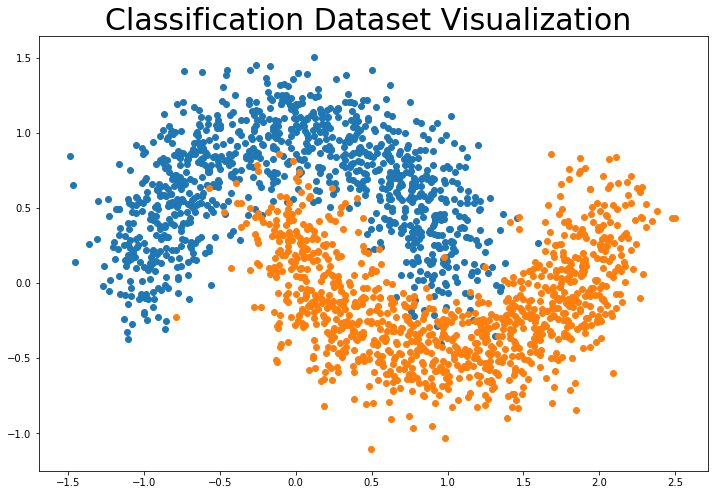

In [5]:
make_plot(X, y, "Classification Dataset Visualization ") 

### 2. 网络层
- 通过新建类 `Layer` 实现一个网络层，需要传入网络层的输入节点数、输出节点数、激 活函数类型等参数
- 权值 `weights` 和偏置张量 `bias` 在初始化时根据输入、输出节点数自动 生成并初始化

In [6]:
class Layer:
    # 全链接网络层
    def __init__(self, n_input, n_output, activation=None, weights=None, bias=None):
        """
        :param int n_input: 输入节点数 
        :param int n_output: 输出节点数         
        :param str activation: 激活函数类型         
        :param weights: 权值张量，默认类内部生成         
        :param bias: 偏置，默认类内部生成 
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_output) * np.sqrt(1 / n_output) 
        self.bias = bias if bias is not None else np.random.rand(n_output) * 0.1
        self.activation = activation # 激活函数类型，如’sigmoid’         
        self.activation_output = None # 激活函数的输出值 o         
        self.error = None  # 用于计算当前层的 delta 变量的中间变量 
        self.delta = None  # 记录当前层的 delta 变量，用于计算梯度 
    
    def activate(self, X):
        # 前向计算函数
        r = np.dot(X, self.weights) + self.bias # X@W + b
        # 通过激活函数，得到全连接层的输出 o (activation_output)      
        self.activation_output = self._apply_activation(r) 
        return self.activation_output
    
    def _apply_activation(self, r): # 计算激活函数的输出
        if self.activation is None:
            return r # 无激活函数，直接返回
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        
        return r
    
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数， 导数为 1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数
        elif self.activation == 'relu':             
            grad = np.array(r, copy=True)             
            grad[r > 0] = 1.             
            grad[r <= 0] = 0.             
            return grad
        # tanh 函数的导数实现         
        elif self.activation == 'tanh':             
            return 1 - r ** 2 
        # Sigmoid 函数的导数实现         
        elif self.activation == 'sigmoid': 
            return r * (1 - r)
        return r

### 3. 网络模型
- 创建单层网络类后，我们实现网络模型的 `NeuralNetwork` 类
- 它内部维护各层的网络 层 `Layer` 类对象，可以通过 `add_layer` 函数追加网络层，
- 实现创建不同结构的网络模型目 的。

In [7]:
y_test.flatten().shape

(600,)

In [8]:
class NeuralNetwork:
    def __init__(self):
        self._layers = [] # 网络层对象列表
    
    def add_layer(self, layer):
        self._layers.append(layer)
    
    def feed_forward(self, X):
        # 前向传播（求导）
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 向前计算，得到最终输出值
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): # 反向循环
            layer = self._layers[i]
            if layer == self._layers[-1]: # 如果是输出层
                layer.error = y - output
                # 计算最后一层的 delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: # 如果是隐藏层
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error*layer.apply_activation_derivative(layer.activation_output)
        
        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].activation_output)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号 
            layer.weights += layer.delta * o_i.T * learning_rate 
    
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2)) 
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = [] 
        for i in range(max_epochs):  # 训练 100 个 epoch             
            for j in range(len(X_train)):  # 一次训练一个样本                 
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)             
                if i % 10 == 0: 
                    # 打印出 MSE Loss                 
                    mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))                 
                    mses.append(mse)                 
                    print('Epoch: #%s, MSE: %f, Accuracy: %.2f%%' % 
                          (i, float(mse), self.accuracy(self.predict(X_test), y_test.flatten()) * 100)) 

        return mses
    
    def accuracy(self, y_predict, y_test): # 计算准确度
        return np.sum(y_predict == y_test) / len(y_test)
    
    def predict(self, X_predict):
        y_predict = self.feed_forward(X_predict) # 此时的 y_predict 形状是 [600 * 2]，第二个维度表示两个输出的概率
        y_predict = np.argmax(y_predict, axis=1)
        return y_predict        

### 4. 网络训练

In [9]:
nn = NeuralNetwork() # 实例化网络类 
nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25 
nn.add_layer(Layer(25, 50, 'sigmoid')) # 隐藏层 2, 25=>50 
nn.add_layer(Layer(50, 25, 'sigmoid')) # 隐藏层 3, 50=>25 
nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2 

In [10]:
nn.train(X_train, X_test, y_train, y_test, learning_rate=0.01, max_epochs=50)

Epoch: #0, MSE: 0.341386, Accuracy: 50.50%
Epoch: #0, MSE: 0.341193, Accuracy: 50.50%
Epoch: #0, MSE: 0.340988, Accuracy: 50.50%
Epoch: #0, MSE: 0.340790, Accuracy: 50.50%
Epoch: #0, MSE: 0.340582, Accuracy: 50.50%
Epoch: #0, MSE: 0.340375, Accuracy: 50.50%
Epoch: #0, MSE: 0.340173, Accuracy: 50.50%
Epoch: #0, MSE: 0.339955, Accuracy: 50.50%
Epoch: #0, MSE: 0.339746, Accuracy: 50.50%
Epoch: #0, MSE: 0.339542, Accuracy: 50.50%
Epoch: #0, MSE: 0.339309, Accuracy: 50.50%
Epoch: #0, MSE: 0.339103, Accuracy: 50.50%
Epoch: #0, MSE: 0.338918, Accuracy: 50.50%
Epoch: #0, MSE: 0.338671, Accuracy: 50.50%
Epoch: #0, MSE: 0.338430, Accuracy: 50.50%
Epoch: #0, MSE: 0.338231, Accuracy: 50.50%
Epoch: #0, MSE: 0.337979, Accuracy: 50.50%
Epoch: #0, MSE: 0.337789, Accuracy: 50.50%
Epoch: #0, MSE: 0.337619, Accuracy: 50.50%
Epoch: #0, MSE: 0.337472, Accuracy: 50.50%
Epoch: #0, MSE: 0.337177, Accuracy: 50.50%
Epoch: #0, MSE: 0.337035, Accuracy: 50.50%
Epoch: #0, MSE: 0.336920, Accuracy: 50.50%
Epoch: #0, 

Epoch: #0, MSE: 0.269617, Accuracy: 50.50%
Epoch: #0, MSE: 0.270123, Accuracy: 50.50%
Epoch: #0, MSE: 0.268979, Accuracy: 50.50%
Epoch: #0, MSE: 0.269492, Accuracy: 50.50%
Epoch: #0, MSE: 0.268361, Accuracy: 50.50%
Epoch: #0, MSE: 0.268867, Accuracy: 50.50%
Epoch: #0, MSE: 0.269394, Accuracy: 50.50%
Epoch: #0, MSE: 0.269934, Accuracy: 50.50%
Epoch: #0, MSE: 0.268769, Accuracy: 50.50%
Epoch: #0, MSE: 0.269304, Accuracy: 50.50%
Epoch: #0, MSE: 0.269854, Accuracy: 50.50%
Epoch: #0, MSE: 0.268676, Accuracy: 50.50%
Epoch: #0, MSE: 0.269234, Accuracy: 50.50%
Epoch: #0, MSE: 0.268064, Accuracy: 50.50%
Epoch: #0, MSE: 0.268618, Accuracy: 50.50%
Epoch: #0, MSE: 0.267464, Accuracy: 50.50%
Epoch: #0, MSE: 0.268022, Accuracy: 50.50%
Epoch: #0, MSE: 0.266878, Accuracy: 50.50%
Epoch: #0, MSE: 0.267437, Accuracy: 50.50%
Epoch: #0, MSE: 0.266308, Accuracy: 50.50%
Epoch: #0, MSE: 0.266875, Accuracy: 50.50%
Epoch: #0, MSE: 0.267448, Accuracy: 50.50%
Epoch: #0, MSE: 0.266305, Accuracy: 50.50%
Epoch: #0, 

Epoch: #0, MSE: 0.254561, Accuracy: 49.50%
Epoch: #0, MSE: 0.255074, Accuracy: 49.50%
Epoch: #0, MSE: 0.255611, Accuracy: 49.50%
Epoch: #0, MSE: 0.254893, Accuracy: 49.50%
Epoch: #0, MSE: 0.254228, Accuracy: 49.50%
Epoch: #0, MSE: 0.253615, Accuracy: 49.50%
Epoch: #0, MSE: 0.254085, Accuracy: 49.50%
Epoch: #0, MSE: 0.253485, Accuracy: 49.50%
Epoch: #0, MSE: 0.252937, Accuracy: 49.50%
Epoch: #0, MSE: 0.253366, Accuracy: 49.50%
Epoch: #0, MSE: 0.252831, Accuracy: 49.50%
Epoch: #0, MSE: 0.253253, Accuracy: 49.50%
Epoch: #0, MSE: 0.253703, Accuracy: 49.50%
Epoch: #0, MSE: 0.254176, Accuracy: 49.50%
Epoch: #0, MSE: 0.253567, Accuracy: 49.50%
Epoch: #0, MSE: 0.253012, Accuracy: 49.50%
Epoch: #0, MSE: 0.253448, Accuracy: 49.50%
Epoch: #0, MSE: 0.253907, Accuracy: 49.50%
Epoch: #0, MSE: 0.254393, Accuracy: 49.50%
Epoch: #0, MSE: 0.254901, Accuracy: 49.50%
Epoch: #0, MSE: 0.255429, Accuracy: 49.50%
Epoch: #0, MSE: 0.254724, Accuracy: 49.50%
Epoch: #0, MSE: 0.255247, Accuracy: 49.50%
Epoch: #0, 

Epoch: #0, MSE: 0.252764, Accuracy: 49.50%
Epoch: #0, MSE: 0.253191, Accuracy: 49.50%
Epoch: #0, MSE: 0.253648, Accuracy: 49.50%
Epoch: #0, MSE: 0.253072, Accuracy: 49.50%
Epoch: #0, MSE: 0.253518, Accuracy: 49.50%
Epoch: #0, MSE: 0.253995, Accuracy: 49.50%
Epoch: #0, MSE: 0.253389, Accuracy: 49.50%
Epoch: #0, MSE: 0.253858, Accuracy: 49.50%
Epoch: #0, MSE: 0.254350, Accuracy: 49.50%
Epoch: #0, MSE: 0.253714, Accuracy: 49.50%
Epoch: #0, MSE: 0.254199, Accuracy: 49.50%
Epoch: #0, MSE: 0.253575, Accuracy: 49.50%
Epoch: #0, MSE: 0.253005, Accuracy: 49.50%
Epoch: #0, MSE: 0.252487, Accuracy: 49.50%
Epoch: #0, MSE: 0.252898, Accuracy: 49.50%
Epoch: #0, MSE: 0.252390, Accuracy: 49.50%
Epoch: #0, MSE: 0.252795, Accuracy: 49.50%
Epoch: #0, MSE: 0.253230, Accuracy: 49.50%
Epoch: #0, MSE: 0.253687, Accuracy: 49.50%
Epoch: #0, MSE: 0.253106, Accuracy: 49.50%
Epoch: #0, MSE: 0.252578, Accuracy: 49.50%
Epoch: #0, MSE: 0.252102, Accuracy: 49.50%
Epoch: #0, MSE: 0.251680, Accuracy: 49.50%
Epoch: #0, 

Epoch: #0, MSE: 0.253870, Accuracy: 50.50%
Epoch: #0, MSE: 0.254381, Accuracy: 50.50%
Epoch: #0, MSE: 0.253724, Accuracy: 50.50%
Epoch: #0, MSE: 0.254226, Accuracy: 50.50%
Epoch: #0, MSE: 0.253581, Accuracy: 50.50%
Epoch: #0, MSE: 0.252992, Accuracy: 50.50%
Epoch: #0, MSE: 0.253453, Accuracy: 50.50%
Epoch: #0, MSE: 0.252874, Accuracy: 50.50%
Epoch: #0, MSE: 0.252350, Accuracy: 50.50%
Epoch: #0, MSE: 0.251879, Accuracy: 50.50%
Epoch: #0, MSE: 0.251461, Accuracy: 50.50%
Epoch: #0, MSE: 0.251096, Accuracy: 50.50%
Epoch: #0, MSE: 0.250781, Accuracy: 50.50%
Epoch: #0, MSE: 0.251055, Accuracy: 50.50%
Epoch: #0, MSE: 0.250746, Accuracy: 50.50%
Epoch: #0, MSE: 0.250488, Accuracy: 50.50%
Epoch: #0, MSE: 0.250718, Accuracy: 50.50%
Epoch: #0, MSE: 0.250983, Accuracy: 50.50%
Epoch: #0, MSE: 0.250685, Accuracy: 50.50%
Epoch: #0, MSE: 0.250437, Accuracy: 50.50%
Epoch: #0, MSE: 0.250661, Accuracy: 50.50%
Epoch: #0, MSE: 0.250417, Accuracy: 50.50%
Epoch: #0, MSE: 0.250634, Accuracy: 50.50%
Epoch: #0, 

Epoch: #0, MSE: 0.250620, Accuracy: 49.50%
Epoch: #0, MSE: 0.250887, Accuracy: 49.50%
Epoch: #0, MSE: 0.250583, Accuracy: 49.50%
Epoch: #0, MSE: 0.250845, Accuracy: 49.50%
Epoch: #0, MSE: 0.250546, Accuracy: 49.50%
Epoch: #0, MSE: 0.250299, Accuracy: 49.50%
Epoch: #0, MSE: 0.250099, Accuracy: 49.50%
Epoch: #0, MSE: 0.250279, Accuracy: 49.50%
Epoch: #0, MSE: 0.250083, Accuracy: 49.50%
Epoch: #0, MSE: 0.250260, Accuracy: 49.50%
Epoch: #0, MSE: 0.250068, Accuracy: 49.50%
Epoch: #0, MSE: 0.250240, Accuracy: 49.50%
Epoch: #0, MSE: 0.250447, Accuracy: 49.50%
Epoch: #0, MSE: 0.250690, Accuracy: 49.50%
Epoch: #0, MSE: 0.250969, Accuracy: 49.50%
Epoch: #0, MSE: 0.251278, Accuracy: 49.50%
Epoch: #0, MSE: 0.250918, Accuracy: 49.50%
Epoch: #0, MSE: 0.250607, Accuracy: 49.50%
Epoch: #0, MSE: 0.250346, Accuracy: 49.50%
Epoch: #0, MSE: 0.250134, Accuracy: 49.50%
Epoch: #0, MSE: 0.249970, Accuracy: 49.50%
Epoch: #0, MSE: 0.249855, Accuracy: 49.50%
Epoch: #0, MSE: 0.249783, Accuracy: 49.50%
Epoch: #0, 

Epoch: #0, MSE: 0.249655, Accuracy: 50.50%
Epoch: #0, MSE: 0.249737, Accuracy: 50.50%
Epoch: #0, MSE: 0.249859, Accuracy: 50.50%
Epoch: #0, MSE: 0.250020, Accuracy: 50.50%
Epoch: #0, MSE: 0.250219, Accuracy: 50.50%
Epoch: #0, MSE: 0.250456, Accuracy: 50.50%
Epoch: #0, MSE: 0.250196, Accuracy: 50.50%
Epoch: #0, MSE: 0.250431, Accuracy: 50.50%
Epoch: #0, MSE: 0.250703, Accuracy: 50.50%
Epoch: #0, MSE: 0.250402, Accuracy: 50.50%
Epoch: #0, MSE: 0.250667, Accuracy: 50.50%
Epoch: #0, MSE: 0.250371, Accuracy: 50.50%
Epoch: #0, MSE: 0.250632, Accuracy: 50.50%
Epoch: #0, MSE: 0.250928, Accuracy: 50.50%
Epoch: #0, MSE: 0.250593, Accuracy: 50.50%
Epoch: #0, MSE: 0.250882, Accuracy: 50.50%
Epoch: #0, MSE: 0.251203, Accuracy: 50.50%
Epoch: #0, MSE: 0.250831, Accuracy: 50.50%
Epoch: #0, MSE: 0.251150, Accuracy: 50.50%
Epoch: #0, MSE: 0.251502, Accuracy: 50.50%
Epoch: #0, MSE: 0.251092, Accuracy: 50.50%
Epoch: #0, MSE: 0.250734, Accuracy: 50.50%
Epoch: #0, MSE: 0.250427, Accuracy: 50.50%
Epoch: #0, 

Epoch: #10, MSE: 0.218572, Accuracy: 79.00%
Epoch: #10, MSE: 0.218564, Accuracy: 78.50%
Epoch: #10, MSE: 0.218601, Accuracy: 79.00%
Epoch: #10, MSE: 0.218535, Accuracy: 78.50%
Epoch: #10, MSE: 0.218603, Accuracy: 78.83%
Epoch: #10, MSE: 0.218535, Accuracy: 78.33%
Epoch: #10, MSE: 0.218602, Accuracy: 79.00%
Epoch: #10, MSE: 0.218707, Accuracy: 79.00%
Epoch: #10, MSE: 0.218904, Accuracy: 78.67%
Epoch: #10, MSE: 0.219092, Accuracy: 79.17%
Epoch: #10, MSE: 0.219331, Accuracy: 78.00%
Epoch: #10, MSE: 0.219036, Accuracy: 79.00%
Epoch: #10, MSE: 0.219242, Accuracy: 79.17%
Epoch: #10, MSE: 0.219542, Accuracy: 78.33%
Epoch: #10, MSE: 0.219181, Accuracy: 79.50%
Epoch: #10, MSE: 0.219412, Accuracy: 78.17%
Epoch: #10, MSE: 0.219081, Accuracy: 78.67%
Epoch: #10, MSE: 0.219316, Accuracy: 78.00%
Epoch: #10, MSE: 0.219656, Accuracy: 78.17%
Epoch: #10, MSE: 0.219314, Accuracy: 78.00%
Epoch: #10, MSE: 0.219050, Accuracy: 78.67%
Epoch: #10, MSE: 0.218800, Accuracy: 78.83%
Epoch: #10, MSE: 0.218597, Accur

Epoch: #10, MSE: 0.220162, Accuracy: 74.17%
Epoch: #10, MSE: 0.219598, Accuracy: 76.67%
Epoch: #10, MSE: 0.220018, Accuracy: 75.00%
Epoch: #10, MSE: 0.220642, Accuracy: 72.17%
Epoch: #10, MSE: 0.221052, Accuracy: 69.17%
Epoch: #10, MSE: 0.221701, Accuracy: 66.33%
Epoch: #10, MSE: 0.222140, Accuracy: 63.67%
Epoch: #10, MSE: 0.221389, Accuracy: 68.00%
Epoch: #10, MSE: 0.221913, Accuracy: 64.50%
Epoch: #10, MSE: 0.221161, Accuracy: 68.50%
Epoch: #10, MSE: 0.220398, Accuracy: 72.83%
Epoch: #10, MSE: 0.219708, Accuracy: 75.67%
Epoch: #10, MSE: 0.219166, Accuracy: 77.83%
Epoch: #10, MSE: 0.218683, Accuracy: 79.00%
Epoch: #10, MSE: 0.219041, Accuracy: 78.17%
Epoch: #10, MSE: 0.219437, Accuracy: 76.67%
Epoch: #10, MSE: 0.218913, Accuracy: 78.33%
Epoch: #10, MSE: 0.218434, Accuracy: 79.00%
Epoch: #10, MSE: 0.217998, Accuracy: 79.67%
Epoch: #10, MSE: 0.218367, Accuracy: 79.50%
Epoch: #10, MSE: 0.218706, Accuracy: 78.83%
Epoch: #10, MSE: 0.219167, Accuracy: 77.67%
Epoch: #10, MSE: 0.219651, Accur

Epoch: #10, MSE: 0.215414, Accuracy: 80.33%
Epoch: #10, MSE: 0.215248, Accuracy: 80.00%
Epoch: #10, MSE: 0.215352, Accuracy: 80.00%
Epoch: #10, MSE: 0.215486, Accuracy: 79.83%
Epoch: #10, MSE: 0.215736, Accuracy: 80.33%
Epoch: #10, MSE: 0.215962, Accuracy: 80.50%
Epoch: #10, MSE: 0.215664, Accuracy: 80.17%
Epoch: #10, MSE: 0.215961, Accuracy: 80.50%
Epoch: #10, MSE: 0.215624, Accuracy: 80.33%
Epoch: #10, MSE: 0.215829, Accuracy: 80.17%
Epoch: #10, MSE: 0.216054, Accuracy: 80.00%
Epoch: #10, MSE: 0.215728, Accuracy: 80.00%
Epoch: #10, MSE: 0.215949, Accuracy: 80.50%
Epoch: #10, MSE: 0.215647, Accuracy: 80.17%
Epoch: #10, MSE: 0.215364, Accuracy: 79.83%
Epoch: #10, MSE: 0.215534, Accuracy: 80.17%
Epoch: #10, MSE: 0.215276, Accuracy: 80.50%
Epoch: #10, MSE: 0.215428, Accuracy: 80.33%
Epoch: #10, MSE: 0.215632, Accuracy: 80.17%
Epoch: #10, MSE: 0.215911, Accuracy: 80.33%
Epoch: #10, MSE: 0.216280, Accuracy: 80.00%
Epoch: #10, MSE: 0.216751, Accuracy: 79.00%
Epoch: #10, MSE: 0.216311, Accur

Epoch: #10, MSE: 0.213228, Accuracy: 79.17%
Epoch: #10, MSE: 0.213263, Accuracy: 79.50%
Epoch: #10, MSE: 0.213226, Accuracy: 79.00%
Epoch: #10, MSE: 0.213233, Accuracy: 79.67%
Epoch: #10, MSE: 0.213216, Accuracy: 79.17%
Epoch: #10, MSE: 0.213230, Accuracy: 78.83%
Epoch: #10, MSE: 0.213298, Accuracy: 79.00%
Epoch: #10, MSE: 0.213403, Accuracy: 78.83%
Epoch: #10, MSE: 0.213263, Accuracy: 79.00%
Epoch: #10, MSE: 0.213182, Accuracy: 78.50%
Epoch: #10, MSE: 0.213159, Accuracy: 79.17%
Epoch: #10, MSE: 0.213172, Accuracy: 79.50%
Epoch: #10, MSE: 0.213225, Accuracy: 80.17%
Epoch: #10, MSE: 0.213129, Accuracy: 79.83%
Epoch: #10, MSE: 0.213205, Accuracy: 80.17%
Epoch: #10, MSE: 0.213320, Accuracy: 79.83%
Epoch: #10, MSE: 0.213470, Accuracy: 80.50%
Epoch: #10, MSE: 0.213284, Accuracy: 79.83%
Epoch: #10, MSE: 0.213145, Accuracy: 80.17%
Epoch: #10, MSE: 0.213245, Accuracy: 79.83%
Epoch: #10, MSE: 0.213470, Accuracy: 79.67%
Epoch: #10, MSE: 0.213264, Accuracy: 80.00%
Epoch: #10, MSE: 0.213438, Accur

Epoch: #10, MSE: 0.211481, Accuracy: 78.83%
Epoch: #10, MSE: 0.211545, Accuracy: 79.00%
Epoch: #10, MSE: 0.211636, Accuracy: 78.83%
Epoch: #10, MSE: 0.211491, Accuracy: 79.00%
Epoch: #10, MSE: 0.211398, Accuracy: 78.50%
Epoch: #10, MSE: 0.211468, Accuracy: 79.00%
Epoch: #10, MSE: 0.211565, Accuracy: 78.83%
Epoch: #10, MSE: 0.211699, Accuracy: 78.83%
Epoch: #10, MSE: 0.211986, Accuracy: 78.83%
Epoch: #10, MSE: 0.212198, Accuracy: 79.33%
Epoch: #10, MSE: 0.211859, Accuracy: 79.33%
Epoch: #10, MSE: 0.211607, Accuracy: 78.83%
Epoch: #10, MSE: 0.211808, Accuracy: 79.50%
Epoch: #10, MSE: 0.211571, Accuracy: 79.00%
Epoch: #10, MSE: 0.211422, Accuracy: 79.00%
Epoch: #10, MSE: 0.211331, Accuracy: 78.83%
Epoch: #10, MSE: 0.211443, Accuracy: 79.00%
Epoch: #10, MSE: 0.211343, Accuracy: 78.67%
Epoch: #10, MSE: 0.211454, Accuracy: 79.17%
Epoch: #10, MSE: 0.211555, Accuracy: 79.00%
Epoch: #10, MSE: 0.211394, Accuracy: 79.00%
Epoch: #10, MSE: 0.211532, Accuracy: 79.00%
Epoch: #10, MSE: 0.211649, Accur

Epoch: #10, MSE: 0.209526, Accuracy: 80.67%
Epoch: #10, MSE: 0.209703, Accuracy: 80.00%
Epoch: #10, MSE: 0.209844, Accuracy: 80.50%
Epoch: #10, MSE: 0.209647, Accuracy: 79.83%
Epoch: #10, MSE: 0.209826, Accuracy: 80.50%
Epoch: #10, MSE: 0.210029, Accuracy: 80.67%
Epoch: #10, MSE: 0.210233, Accuracy: 80.17%
Epoch: #10, MSE: 0.209942, Accuracy: 80.33%
Epoch: #10, MSE: 0.209701, Accuracy: 80.33%
Epoch: #10, MSE: 0.210019, Accuracy: 80.67%
Epoch: #10, MSE: 0.210205, Accuracy: 80.17%
Epoch: #10, MSE: 0.210573, Accuracy: 80.50%
Epoch: #10, MSE: 0.211078, Accuracy: 80.17%
Epoch: #10, MSE: 0.211580, Accuracy: 79.50%
Epoch: #10, MSE: 0.212133, Accuracy: 79.00%
Epoch: #10, MSE: 0.212527, Accuracy: 78.33%
Epoch: #10, MSE: 0.212962, Accuracy: 77.67%
Epoch: #10, MSE: 0.212221, Accuracy: 79.17%
Epoch: #10, MSE: 0.211607, Accuracy: 79.50%
Epoch: #10, MSE: 0.211091, Accuracy: 79.67%
Epoch: #10, MSE: 0.210615, Accuracy: 80.67%
Epoch: #10, MSE: 0.210919, Accuracy: 80.17%
Epoch: #10, MSE: 0.210447, Accur

Epoch: #10, MSE: 0.207647, Accuracy: 80.67%
Epoch: #10, MSE: 0.207855, Accuracy: 80.33%
Epoch: #10, MSE: 0.208054, Accuracy: 80.67%
Epoch: #10, MSE: 0.208264, Accuracy: 80.33%
Epoch: #10, MSE: 0.208565, Accuracy: 80.33%
Epoch: #10, MSE: 0.208846, Accuracy: 80.50%
Epoch: #10, MSE: 0.208390, Accuracy: 80.33%
Epoch: #10, MSE: 0.208744, Accuracy: 80.50%
Epoch: #10, MSE: 0.209064, Accuracy: 80.17%
Epoch: #10, MSE: 0.209403, Accuracy: 80.00%
Epoch: #10, MSE: 0.208951, Accuracy: 80.33%
Epoch: #10, MSE: 0.209412, Accuracy: 80.00%
Epoch: #10, MSE: 0.209921, Accuracy: 79.50%
Epoch: #10, MSE: 0.210616, Accuracy: 79.17%
Epoch: #10, MSE: 0.211039, Accuracy: 78.17%
Epoch: #10, MSE: 0.210429, Accuracy: 79.17%
Epoch: #10, MSE: 0.209758, Accuracy: 79.67%
Epoch: #10, MSE: 0.210333, Accuracy: 79.00%
Epoch: #10, MSE: 0.210778, Accuracy: 78.33%
Epoch: #10, MSE: 0.210083, Accuracy: 79.17%
Epoch: #10, MSE: 0.209451, Accuracy: 80.00%
Epoch: #10, MSE: 0.208952, Accuracy: 80.17%
Epoch: #10, MSE: 0.208532, Accur

Epoch: #20, MSE: 0.108766, Accuracy: 86.00%
Epoch: #20, MSE: 0.108840, Accuracy: 86.00%
Epoch: #20, MSE: 0.108825, Accuracy: 86.00%
Epoch: #20, MSE: 0.108798, Accuracy: 86.00%
Epoch: #20, MSE: 0.108784, Accuracy: 86.00%
Epoch: #20, MSE: 0.108800, Accuracy: 86.00%
Epoch: #20, MSE: 0.108789, Accuracy: 86.00%
Epoch: #20, MSE: 0.108779, Accuracy: 86.00%
Epoch: #20, MSE: 0.108926, Accuracy: 86.33%
Epoch: #20, MSE: 0.108807, Accuracy: 86.00%
Epoch: #20, MSE: 0.108812, Accuracy: 86.00%
Epoch: #20, MSE: 0.108817, Accuracy: 86.00%
Epoch: #20, MSE: 0.108805, Accuracy: 86.00%
Epoch: #20, MSE: 0.108738, Accuracy: 86.00%
Epoch: #20, MSE: 0.108734, Accuracy: 86.00%
Epoch: #20, MSE: 0.108734, Accuracy: 86.00%
Epoch: #20, MSE: 0.108735, Accuracy: 86.00%
Epoch: #20, MSE: 0.108750, Accuracy: 86.17%
Epoch: #20, MSE: 0.108766, Accuracy: 86.17%
Epoch: #20, MSE: 0.108774, Accuracy: 86.00%
Epoch: #20, MSE: 0.108741, Accuracy: 86.00%
Epoch: #20, MSE: 0.108827, Accuracy: 86.00%
Epoch: #20, MSE: 0.108813, Accur

Epoch: #20, MSE: 0.109161, Accuracy: 87.50%
Epoch: #20, MSE: 0.109114, Accuracy: 87.33%
Epoch: #20, MSE: 0.109016, Accuracy: 87.00%
Epoch: #20, MSE: 0.109097, Accuracy: 87.33%
Epoch: #20, MSE: 0.109065, Accuracy: 87.33%
Epoch: #20, MSE: 0.109080, Accuracy: 87.33%
Epoch: #20, MSE: 0.109172, Accuracy: 87.50%
Epoch: #20, MSE: 0.109181, Accuracy: 87.50%
Epoch: #20, MSE: 0.108849, Accuracy: 87.17%
Epoch: #20, MSE: 0.108861, Accuracy: 87.17%
Epoch: #20, MSE: 0.108905, Accuracy: 87.00%
Epoch: #20, MSE: 0.108922, Accuracy: 87.00%
Epoch: #20, MSE: 0.108983, Accuracy: 87.00%
Epoch: #20, MSE: 0.108801, Accuracy: 87.17%
Epoch: #20, MSE: 0.108573, Accuracy: 86.67%
Epoch: #20, MSE: 0.108526, Accuracy: 86.50%
Epoch: #20, MSE: 0.108596, Accuracy: 86.67%
Epoch: #20, MSE: 0.108571, Accuracy: 86.67%
Epoch: #20, MSE: 0.108579, Accuracy: 86.67%
Epoch: #20, MSE: 0.108564, Accuracy: 86.67%
Epoch: #20, MSE: 0.108594, Accuracy: 86.67%
Epoch: #20, MSE: 0.108890, Accuracy: 87.00%
Epoch: #20, MSE: 0.108759, Accur

Epoch: #20, MSE: 0.108012, Accuracy: 86.17%
Epoch: #20, MSE: 0.108038, Accuracy: 86.17%
Epoch: #20, MSE: 0.108053, Accuracy: 86.17%
Epoch: #20, MSE: 0.108045, Accuracy: 86.17%
Epoch: #20, MSE: 0.108054, Accuracy: 86.17%
Epoch: #20, MSE: 0.107960, Accuracy: 86.00%
Epoch: #20, MSE: 0.107956, Accuracy: 86.00%
Epoch: #20, MSE: 0.107975, Accuracy: 86.17%
Epoch: #20, MSE: 0.108030, Accuracy: 86.17%
Epoch: #20, MSE: 0.107996, Accuracy: 86.17%
Epoch: #20, MSE: 0.108017, Accuracy: 86.17%
Epoch: #20, MSE: 0.108022, Accuracy: 86.17%
Epoch: #20, MSE: 0.108137, Accuracy: 86.50%
Epoch: #20, MSE: 0.108144, Accuracy: 86.50%
Epoch: #20, MSE: 0.107920, Accuracy: 86.17%
Epoch: #20, MSE: 0.108060, Accuracy: 86.33%
Epoch: #20, MSE: 0.108085, Accuracy: 86.33%
Epoch: #20, MSE: 0.108146, Accuracy: 86.50%
Epoch: #20, MSE: 0.108161, Accuracy: 86.50%
Epoch: #20, MSE: 0.108167, Accuracy: 86.50%
Epoch: #20, MSE: 0.108125, Accuracy: 86.50%
Epoch: #20, MSE: 0.108088, Accuracy: 86.33%
Epoch: #20, MSE: 0.108125, Accur

Epoch: #20, MSE: 0.107503, Accuracy: 86.17%
Epoch: #20, MSE: 0.107515, Accuracy: 86.17%
Epoch: #20, MSE: 0.107517, Accuracy: 86.17%
Epoch: #20, MSE: 0.107511, Accuracy: 86.17%
Epoch: #20, MSE: 0.107493, Accuracy: 86.17%
Epoch: #20, MSE: 0.107494, Accuracy: 86.17%
Epoch: #20, MSE: 0.107503, Accuracy: 86.17%
Epoch: #20, MSE: 0.107507, Accuracy: 86.17%
Epoch: #20, MSE: 0.107509, Accuracy: 86.17%
Epoch: #20, MSE: 0.107502, Accuracy: 86.17%
Epoch: #20, MSE: 0.107647, Accuracy: 86.17%
Epoch: #20, MSE: 0.107657, Accuracy: 86.33%
Epoch: #20, MSE: 0.107681, Accuracy: 86.33%
Epoch: #20, MSE: 0.107655, Accuracy: 86.33%
Epoch: #20, MSE: 0.107617, Accuracy: 86.17%
Epoch: #20, MSE: 0.107607, Accuracy: 86.17%
Epoch: #20, MSE: 0.107572, Accuracy: 86.17%
Epoch: #20, MSE: 0.107589, Accuracy: 86.17%
Epoch: #20, MSE: 0.107574, Accuracy: 86.17%
Epoch: #20, MSE: 0.107579, Accuracy: 86.33%
Epoch: #20, MSE: 0.107588, Accuracy: 86.17%
Epoch: #20, MSE: 0.107509, Accuracy: 86.33%
Epoch: #20, MSE: 0.107455, Accur

Epoch: #20, MSE: 0.107280, Accuracy: 86.50%
Epoch: #20, MSE: 0.107271, Accuracy: 86.50%
Epoch: #20, MSE: 0.107517, Accuracy: 86.50%
Epoch: #20, MSE: 0.107501, Accuracy: 86.50%
Epoch: #20, MSE: 0.107618, Accuracy: 86.33%
Epoch: #20, MSE: 0.108051, Accuracy: 86.00%
Epoch: #20, MSE: 0.107905, Accuracy: 86.17%
Epoch: #20, MSE: 0.107527, Accuracy: 86.50%
Epoch: #20, MSE: 0.107507, Accuracy: 86.50%
Epoch: #20, MSE: 0.107493, Accuracy: 86.50%
Epoch: #20, MSE: 0.107517, Accuracy: 86.50%
Epoch: #20, MSE: 0.107522, Accuracy: 86.50%
Epoch: #20, MSE: 0.107336, Accuracy: 86.50%
Epoch: #20, MSE: 0.107569, Accuracy: 86.50%
Epoch: #20, MSE: 0.107575, Accuracy: 86.50%
Epoch: #20, MSE: 0.107639, Accuracy: 86.33%
Epoch: #20, MSE: 0.108097, Accuracy: 86.00%
Epoch: #20, MSE: 0.107734, Accuracy: 86.33%
Epoch: #20, MSE: 0.108220, Accuracy: 85.83%
Epoch: #20, MSE: 0.107760, Accuracy: 86.33%
Epoch: #20, MSE: 0.107786, Accuracy: 86.33%
Epoch: #20, MSE: 0.107768, Accuracy: 86.33%
Epoch: #20, MSE: 0.107790, Accur

Epoch: #20, MSE: 0.106873, Accuracy: 87.00%
Epoch: #20, MSE: 0.106888, Accuracy: 87.00%
Epoch: #20, MSE: 0.107236, Accuracy: 87.67%
Epoch: #20, MSE: 0.107260, Accuracy: 87.67%
Epoch: #20, MSE: 0.107591, Accuracy: 87.83%
Epoch: #20, MSE: 0.107603, Accuracy: 87.83%
Epoch: #20, MSE: 0.107571, Accuracy: 87.67%
Epoch: #20, MSE: 0.107286, Accuracy: 87.67%
Epoch: #20, MSE: 0.107305, Accuracy: 87.67%
Epoch: #20, MSE: 0.107262, Accuracy: 87.67%
Epoch: #20, MSE: 0.107149, Accuracy: 87.50%
Epoch: #20, MSE: 0.107362, Accuracy: 87.67%
Epoch: #20, MSE: 0.107386, Accuracy: 87.67%
Epoch: #20, MSE: 0.107187, Accuracy: 87.67%
Epoch: #20, MSE: 0.106983, Accuracy: 87.17%
Epoch: #20, MSE: 0.107293, Accuracy: 87.67%
Epoch: #20, MSE: 0.107263, Accuracy: 87.67%
Epoch: #20, MSE: 0.107177, Accuracy: 87.50%
Epoch: #20, MSE: 0.107002, Accuracy: 87.17%
Epoch: #20, MSE: 0.106958, Accuracy: 87.17%
Epoch: #20, MSE: 0.106929, Accuracy: 87.17%
Epoch: #20, MSE: 0.107311, Accuracy: 87.67%
Epoch: #20, MSE: 0.107320, Accur

Epoch: #20, MSE: 0.106112, Accuracy: 86.17%
Epoch: #20, MSE: 0.106112, Accuracy: 86.33%
Epoch: #20, MSE: 0.106128, Accuracy: 86.33%
Epoch: #20, MSE: 0.106133, Accuracy: 86.50%
Epoch: #20, MSE: 0.106123, Accuracy: 86.33%
Epoch: #20, MSE: 0.106124, Accuracy: 86.33%
Epoch: #20, MSE: 0.106149, Accuracy: 86.50%
Epoch: #20, MSE: 0.106134, Accuracy: 86.50%
Epoch: #20, MSE: 0.106160, Accuracy: 86.67%
Epoch: #20, MSE: 0.106182, Accuracy: 86.83%
Epoch: #20, MSE: 0.106267, Accuracy: 86.67%
Epoch: #20, MSE: 0.106505, Accuracy: 86.50%
Epoch: #20, MSE: 0.106491, Accuracy: 86.50%
Epoch: #20, MSE: 0.106463, Accuracy: 86.50%
Epoch: #20, MSE: 0.106416, Accuracy: 86.50%
Epoch: #20, MSE: 0.106407, Accuracy: 86.50%
Epoch: #20, MSE: 0.106415, Accuracy: 86.50%
Epoch: #20, MSE: 0.106462, Accuracy: 86.50%
Epoch: #20, MSE: 0.106605, Accuracy: 86.50%
Epoch: #20, MSE: 0.106641, Accuracy: 86.50%
Epoch: #20, MSE: 0.106652, Accuracy: 86.50%
Epoch: #20, MSE: 0.106828, Accuracy: 86.33%
Epoch: #20, MSE: 0.106780, Accur

Epoch: #30, MSE: 0.096914, Accuracy: 88.83%
Epoch: #30, MSE: 0.096922, Accuracy: 88.83%
Epoch: #30, MSE: 0.096910, Accuracy: 88.83%
Epoch: #30, MSE: 0.096884, Accuracy: 88.67%
Epoch: #30, MSE: 0.096884, Accuracy: 88.67%
Epoch: #30, MSE: 0.096914, Accuracy: 88.50%
Epoch: #30, MSE: 0.096917, Accuracy: 88.50%
Epoch: #30, MSE: 0.096915, Accuracy: 88.50%
Epoch: #30, MSE: 0.096895, Accuracy: 88.67%
Epoch: #30, MSE: 0.096918, Accuracy: 88.50%
Epoch: #30, MSE: 0.096916, Accuracy: 88.50%
Epoch: #30, MSE: 0.096924, Accuracy: 88.50%
Epoch: #30, MSE: 0.096890, Accuracy: 88.67%
Epoch: #30, MSE: 0.096892, Accuracy: 88.67%
Epoch: #30, MSE: 0.096892, Accuracy: 88.67%
Epoch: #30, MSE: 0.096918, Accuracy: 88.50%
Epoch: #30, MSE: 0.096895, Accuracy: 88.67%
Epoch: #30, MSE: 0.096898, Accuracy: 88.67%
Epoch: #30, MSE: 0.096897, Accuracy: 88.67%
Epoch: #30, MSE: 0.096900, Accuracy: 88.83%
Epoch: #30, MSE: 0.096900, Accuracy: 88.83%
Epoch: #30, MSE: 0.097012, Accuracy: 88.83%
Epoch: #30, MSE: 0.096919, Accur

Epoch: #30, MSE: 0.097146, Accuracy: 88.67%
Epoch: #30, MSE: 0.097161, Accuracy: 88.67%
Epoch: #30, MSE: 0.097153, Accuracy: 88.67%
Epoch: #30, MSE: 0.097158, Accuracy: 88.67%
Epoch: #30, MSE: 0.097162, Accuracy: 88.67%
Epoch: #30, MSE: 0.097141, Accuracy: 88.67%
Epoch: #30, MSE: 0.097138, Accuracy: 88.67%
Epoch: #30, MSE: 0.097128, Accuracy: 88.67%
Epoch: #30, MSE: 0.097301, Accuracy: 88.67%
Epoch: #30, MSE: 0.097610, Accuracy: 89.17%
Epoch: #30, MSE: 0.097576, Accuracy: 89.17%
Epoch: #30, MSE: 0.097216, Accuracy: 88.67%
Epoch: #30, MSE: 0.097116, Accuracy: 88.67%
Epoch: #30, MSE: 0.096942, Accuracy: 88.83%
Epoch: #30, MSE: 0.096963, Accuracy: 88.83%
Epoch: #30, MSE: 0.096960, Accuracy: 88.83%
Epoch: #30, MSE: 0.096959, Accuracy: 88.83%
Epoch: #30, MSE: 0.096952, Accuracy: 88.83%
Epoch: #30, MSE: 0.096945, Accuracy: 88.83%
Epoch: #30, MSE: 0.096943, Accuracy: 88.83%
Epoch: #30, MSE: 0.096940, Accuracy: 88.83%
Epoch: #30, MSE: 0.097134, Accuracy: 88.67%
Epoch: #30, MSE: 0.097062, Accur

Epoch: #30, MSE: 0.096946, Accuracy: 88.17%
Epoch: #30, MSE: 0.096917, Accuracy: 88.33%
Epoch: #30, MSE: 0.096918, Accuracy: 88.33%
Epoch: #30, MSE: 0.096837, Accuracy: 88.67%
Epoch: #30, MSE: 0.096848, Accuracy: 88.50%
Epoch: #30, MSE: 0.096850, Accuracy: 88.50%
Epoch: #30, MSE: 0.096933, Accuracy: 88.17%
Epoch: #30, MSE: 0.096927, Accuracy: 88.33%
Epoch: #30, MSE: 0.096835, Accuracy: 88.67%
Epoch: #30, MSE: 0.096834, Accuracy: 88.67%
Epoch: #30, MSE: 0.096834, Accuracy: 88.67%
Epoch: #30, MSE: 0.096842, Accuracy: 88.50%
Epoch: #30, MSE: 0.096919, Accuracy: 88.33%
Epoch: #30, MSE: 0.096915, Accuracy: 88.33%
Epoch: #30, MSE: 0.096915, Accuracy: 88.33%
Epoch: #30, MSE: 0.096924, Accuracy: 88.33%
Epoch: #30, MSE: 0.096932, Accuracy: 88.17%
Epoch: #30, MSE: 0.096993, Accuracy: 88.50%
Epoch: #30, MSE: 0.096849, Accuracy: 88.50%
Epoch: #30, MSE: 0.096869, Accuracy: 88.50%
Epoch: #30, MSE: 0.097013, Accuracy: 88.50%
Epoch: #30, MSE: 0.096988, Accuracy: 88.33%
Epoch: #30, MSE: 0.096881, Accur

Epoch: #30, MSE: 0.097218, Accuracy: 88.17%
Epoch: #30, MSE: 0.097215, Accuracy: 88.17%
Epoch: #30, MSE: 0.097282, Accuracy: 88.17%
Epoch: #30, MSE: 0.097390, Accuracy: 88.50%
Epoch: #30, MSE: 0.097182, Accuracy: 88.17%
Epoch: #30, MSE: 0.097185, Accuracy: 88.17%
Epoch: #30, MSE: 0.097506, Accuracy: 88.50%
Epoch: #30, MSE: 0.097215, Accuracy: 88.17%
Epoch: #30, MSE: 0.097199, Accuracy: 88.17%
Epoch: #30, MSE: 0.097285, Accuracy: 88.17%
Epoch: #30, MSE: 0.097280, Accuracy: 88.17%
Epoch: #30, MSE: 0.097011, Accuracy: 88.33%
Epoch: #30, MSE: 0.097011, Accuracy: 88.33%
Epoch: #30, MSE: 0.097008, Accuracy: 88.33%
Epoch: #30, MSE: 0.096955, Accuracy: 88.17%
Epoch: #30, MSE: 0.096960, Accuracy: 88.17%
Epoch: #30, MSE: 0.096868, Accuracy: 88.50%
Epoch: #30, MSE: 0.096914, Accuracy: 88.33%
Epoch: #30, MSE: 0.096877, Accuracy: 88.33%
Epoch: #30, MSE: 0.096858, Accuracy: 88.67%
Epoch: #30, MSE: 0.096858, Accuracy: 88.67%
Epoch: #30, MSE: 0.096956, Accuracy: 88.83%
Epoch: #30, MSE: 0.097051, Accur

Epoch: #30, MSE: 0.096845, Accuracy: 88.83%
Epoch: #30, MSE: 0.096863, Accuracy: 88.50%
Epoch: #30, MSE: 0.096844, Accuracy: 88.50%
Epoch: #30, MSE: 0.096843, Accuracy: 88.50%
Epoch: #30, MSE: 0.096838, Accuracy: 88.67%
Epoch: #30, MSE: 0.096838, Accuracy: 88.67%
Epoch: #30, MSE: 0.096914, Accuracy: 88.50%
Epoch: #30, MSE: 0.096908, Accuracy: 88.50%
Epoch: #30, MSE: 0.096909, Accuracy: 88.50%
Epoch: #30, MSE: 0.096908, Accuracy: 88.50%
Epoch: #30, MSE: 0.097071, Accuracy: 88.33%
Epoch: #30, MSE: 0.097068, Accuracy: 88.33%
Epoch: #30, MSE: 0.097284, Accuracy: 88.17%
Epoch: #30, MSE: 0.097670, Accuracy: 88.33%
Epoch: #30, MSE: 0.097602, Accuracy: 88.33%
Epoch: #30, MSE: 0.097272, Accuracy: 88.17%
Epoch: #30, MSE: 0.097263, Accuracy: 88.17%
Epoch: #30, MSE: 0.097260, Accuracy: 88.17%
Epoch: #30, MSE: 0.097275, Accuracy: 88.17%
Epoch: #30, MSE: 0.097276, Accuracy: 88.17%
Epoch: #30, MSE: 0.097169, Accuracy: 88.17%
Epoch: #30, MSE: 0.097368, Accuracy: 88.50%
Epoch: #30, MSE: 0.097368, Accur

Epoch: #30, MSE: 0.097593, Accuracy: 89.00%
Epoch: #30, MSE: 0.097410, Accuracy: 89.17%
Epoch: #30, MSE: 0.097829, Accuracy: 89.17%
Epoch: #30, MSE: 0.097846, Accuracy: 89.17%
Epoch: #30, MSE: 0.097476, Accuracy: 89.00%
Epoch: #30, MSE: 0.097257, Accuracy: 88.67%
Epoch: #30, MSE: 0.097569, Accuracy: 89.17%
Epoch: #30, MSE: 0.097558, Accuracy: 89.17%
Epoch: #30, MSE: 0.097495, Accuracy: 89.17%
Epoch: #30, MSE: 0.097418, Accuracy: 89.00%
Epoch: #30, MSE: 0.097372, Accuracy: 88.83%
Epoch: #30, MSE: 0.097367, Accuracy: 88.83%
Epoch: #30, MSE: 0.097805, Accuracy: 89.17%
Epoch: #30, MSE: 0.097807, Accuracy: 89.17%
Epoch: #30, MSE: 0.097812, Accuracy: 89.17%
Epoch: #30, MSE: 0.098048, Accuracy: 89.17%
Epoch: #30, MSE: 0.098061, Accuracy: 89.17%
Epoch: #30, MSE: 0.098051, Accuracy: 89.17%
Epoch: #30, MSE: 0.098043, Accuracy: 89.17%
Epoch: #30, MSE: 0.098020, Accuracy: 89.17%
Epoch: #30, MSE: 0.098213, Accuracy: 89.00%
Epoch: #30, MSE: 0.098220, Accuracy: 89.00%
Epoch: #30, MSE: 0.098863, Accur

Epoch: #40, MSE: 0.096394, Accuracy: 89.17%
Epoch: #40, MSE: 0.096389, Accuracy: 89.17%
Epoch: #40, MSE: 0.096397, Accuracy: 89.17%
Epoch: #40, MSE: 0.096399, Accuracy: 89.17%
Epoch: #40, MSE: 0.096395, Accuracy: 89.17%
Epoch: #40, MSE: 0.096402, Accuracy: 89.17%
Epoch: #40, MSE: 0.096406, Accuracy: 89.17%
Epoch: #40, MSE: 0.096379, Accuracy: 89.17%
Epoch: #40, MSE: 0.096551, Accuracy: 88.50%
Epoch: #40, MSE: 0.096806, Accuracy: 88.67%
Epoch: #40, MSE: 0.096627, Accuracy: 88.50%
Epoch: #40, MSE: 0.096621, Accuracy: 88.50%
Epoch: #40, MSE: 0.096552, Accuracy: 88.50%
Epoch: #40, MSE: 0.096555, Accuracy: 88.50%
Epoch: #40, MSE: 0.096557, Accuracy: 88.50%
Epoch: #40, MSE: 0.096554, Accuracy: 88.50%
Epoch: #40, MSE: 0.096850, Accuracy: 88.50%
Epoch: #40, MSE: 0.096689, Accuracy: 88.50%
Epoch: #40, MSE: 0.096686, Accuracy: 88.50%
Epoch: #40, MSE: 0.096632, Accuracy: 88.50%
Epoch: #40, MSE: 0.096633, Accuracy: 88.50%
Epoch: #40, MSE: 0.096589, Accuracy: 88.50%
Epoch: #40, MSE: 0.096419, Accur

Epoch: #40, MSE: 0.096299, Accuracy: 89.00%
Epoch: #40, MSE: 0.096299, Accuracy: 89.00%
Epoch: #40, MSE: 0.096299, Accuracy: 89.00%
Epoch: #40, MSE: 0.096300, Accuracy: 88.83%
Epoch: #40, MSE: 0.096299, Accuracy: 88.83%
Epoch: #40, MSE: 0.096299, Accuracy: 89.00%
Epoch: #40, MSE: 0.096345, Accuracy: 89.00%
Epoch: #40, MSE: 0.096329, Accuracy: 88.83%
Epoch: #40, MSE: 0.096328, Accuracy: 88.83%
Epoch: #40, MSE: 0.096334, Accuracy: 89.00%
Epoch: #40, MSE: 0.096334, Accuracy: 89.00%
Epoch: #40, MSE: 0.096331, Accuracy: 88.83%
Epoch: #40, MSE: 0.096323, Accuracy: 88.83%
Epoch: #40, MSE: 0.096299, Accuracy: 89.00%
Epoch: #40, MSE: 0.096301, Accuracy: 89.00%
Epoch: #40, MSE: 0.096301, Accuracy: 89.00%
Epoch: #40, MSE: 0.096304, Accuracy: 89.00%
Epoch: #40, MSE: 0.096303, Accuracy: 89.00%
Epoch: #40, MSE: 0.096302, Accuracy: 89.00%
Epoch: #40, MSE: 0.096398, Accuracy: 88.83%
Epoch: #40, MSE: 0.096395, Accuracy: 88.83%
Epoch: #40, MSE: 0.096396, Accuracy: 88.83%
Epoch: #40, MSE: 0.096466, Accur

Epoch: #40, MSE: 0.096550, Accuracy: 88.50%
Epoch: #40, MSE: 0.096551, Accuracy: 88.50%
Epoch: #40, MSE: 0.096550, Accuracy: 88.50%
Epoch: #40, MSE: 0.096414, Accuracy: 89.17%
Epoch: #40, MSE: 0.096424, Accuracy: 89.17%
Epoch: #40, MSE: 0.096656, Accuracy: 88.50%
Epoch: #40, MSE: 0.096644, Accuracy: 88.50%
Epoch: #40, MSE: 0.096635, Accuracy: 88.50%
Epoch: #40, MSE: 0.096647, Accuracy: 88.50%
Epoch: #40, MSE: 0.097000, Accuracy: 88.33%
Epoch: #40, MSE: 0.097014, Accuracy: 88.33%
Epoch: #40, MSE: 0.097010, Accuracy: 88.33%
Epoch: #40, MSE: 0.097017, Accuracy: 88.33%
Epoch: #40, MSE: 0.096949, Accuracy: 88.33%
Epoch: #40, MSE: 0.096993, Accuracy: 88.33%
Epoch: #40, MSE: 0.097016, Accuracy: 88.33%
Epoch: #40, MSE: 0.097019, Accuracy: 88.33%
Epoch: #40, MSE: 0.097229, Accuracy: 88.50%
Epoch: #40, MSE: 0.097183, Accuracy: 88.50%
Epoch: #40, MSE: 0.097188, Accuracy: 88.50%
Epoch: #40, MSE: 0.097679, Accuracy: 88.83%
Epoch: #40, MSE: 0.097693, Accuracy: 88.83%
Epoch: #40, MSE: 0.097748, Accur

Epoch: #40, MSE: 0.096316, Accuracy: 88.83%
Epoch: #40, MSE: 0.096302, Accuracy: 88.83%
Epoch: #40, MSE: 0.096301, Accuracy: 89.00%
Epoch: #40, MSE: 0.096301, Accuracy: 89.00%
Epoch: #40, MSE: 0.096332, Accuracy: 88.83%
Epoch: #40, MSE: 0.096363, Accuracy: 89.00%
Epoch: #40, MSE: 0.096363, Accuracy: 89.00%
Epoch: #40, MSE: 0.096381, Accuracy: 89.17%
Epoch: #40, MSE: 0.096381, Accuracy: 89.17%
Epoch: #40, MSE: 0.096386, Accuracy: 89.17%
Epoch: #40, MSE: 0.096384, Accuracy: 89.17%
Epoch: #40, MSE: 0.096430, Accuracy: 89.00%
Epoch: #40, MSE: 0.096436, Accuracy: 88.83%
Epoch: #40, MSE: 0.096430, Accuracy: 89.00%
Epoch: #40, MSE: 0.096433, Accuracy: 88.83%
Epoch: #40, MSE: 0.096430, Accuracy: 88.83%
Epoch: #40, MSE: 0.096429, Accuracy: 89.00%
Epoch: #40, MSE: 0.096435, Accuracy: 88.83%
Epoch: #40, MSE: 0.096436, Accuracy: 88.83%
Epoch: #40, MSE: 0.096533, Accuracy: 88.33%
Epoch: #40, MSE: 0.096531, Accuracy: 88.50%
Epoch: #40, MSE: 0.096581, Accuracy: 88.50%
Epoch: #40, MSE: 0.096899, Accur

Epoch: #40, MSE: 0.096306, Accuracy: 88.83%
Epoch: #40, MSE: 0.096306, Accuracy: 88.83%
Epoch: #40, MSE: 0.096360, Accuracy: 88.83%
Epoch: #40, MSE: 0.096436, Accuracy: 88.83%
Epoch: #40, MSE: 0.096440, Accuracy: 88.83%
Epoch: #40, MSE: 0.096343, Accuracy: 88.83%
Epoch: #40, MSE: 0.096336, Accuracy: 88.83%
Epoch: #40, MSE: 0.096329, Accuracy: 88.83%
Epoch: #40, MSE: 0.096331, Accuracy: 88.83%
Epoch: #40, MSE: 0.096330, Accuracy: 88.83%
Epoch: #40, MSE: 0.096331, Accuracy: 88.83%
Epoch: #40, MSE: 0.096334, Accuracy: 88.83%
Epoch: #40, MSE: 0.096327, Accuracy: 88.83%
Epoch: #40, MSE: 0.096325, Accuracy: 88.83%
Epoch: #40, MSE: 0.096432, Accuracy: 88.83%
Epoch: #40, MSE: 0.096439, Accuracy: 88.83%
Epoch: #40, MSE: 0.096323, Accuracy: 88.83%
Epoch: #40, MSE: 0.096322, Accuracy: 88.83%
Epoch: #40, MSE: 0.096322, Accuracy: 88.83%
Epoch: #40, MSE: 0.096353, Accuracy: 88.83%
Epoch: #40, MSE: 0.096355, Accuracy: 88.83%
Epoch: #40, MSE: 0.096374, Accuracy: 88.83%
Epoch: #40, MSE: 0.096376, Accur

Epoch: #40, MSE: 0.096668, Accuracy: 88.50%
Epoch: #40, MSE: 0.096508, Accuracy: 88.67%
Epoch: #40, MSE: 0.096492, Accuracy: 88.67%
Epoch: #40, MSE: 0.096523, Accuracy: 88.83%
Epoch: #40, MSE: 0.096460, Accuracy: 88.83%
Epoch: #40, MSE: 0.096459, Accuracy: 88.83%
Epoch: #40, MSE: 0.096542, Accuracy: 88.50%
Epoch: #40, MSE: 0.096533, Accuracy: 88.67%
Epoch: #40, MSE: 0.096379, Accuracy: 89.17%
Epoch: #40, MSE: 0.096384, Accuracy: 89.17%
Epoch: #40, MSE: 0.096377, Accuracy: 89.17%
Epoch: #40, MSE: 0.096324, Accuracy: 88.83%
Epoch: #40, MSE: 0.096323, Accuracy: 88.83%
Epoch: #40, MSE: 0.096324, Accuracy: 88.83%
Epoch: #40, MSE: 0.096323, Accuracy: 88.83%
Epoch: #40, MSE: 0.096322, Accuracy: 88.83%
Epoch: #40, MSE: 0.096324, Accuracy: 88.83%
Epoch: #40, MSE: 0.096325, Accuracy: 88.83%
Epoch: #40, MSE: 0.096326, Accuracy: 88.83%
Epoch: #40, MSE: 0.096322, Accuracy: 88.83%
Epoch: #40, MSE: 0.096302, Accuracy: 88.83%
Epoch: #40, MSE: 0.096302, Accuracy: 88.83%
Epoch: #40, MSE: 0.096299, Accur

Epoch: #40, MSE: 0.099447, Accuracy: 88.50%
Epoch: #40, MSE: 0.099260, Accuracy: 88.50%
Epoch: #40, MSE: 0.099247, Accuracy: 88.50%
Epoch: #40, MSE: 0.099365, Accuracy: 88.50%
Epoch: #40, MSE: 0.098965, Accuracy: 88.50%
Epoch: #40, MSE: 0.099854, Accuracy: 88.33%
Epoch: #40, MSE: 0.100888, Accuracy: 87.83%
Epoch: #40, MSE: 0.100903, Accuracy: 87.83%
Epoch: #40, MSE: 0.100888, Accuracy: 87.83%
Epoch: #40, MSE: 0.100891, Accuracy: 87.83%
Epoch: #40, MSE: 0.101312, Accuracy: 87.67%
Epoch: #40, MSE: 0.100792, Accuracy: 87.83%
Epoch: #40, MSE: 0.100443, Accuracy: 88.00%
Epoch: #40, MSE: 0.100936, Accuracy: 87.83%
Epoch: #40, MSE: 0.100898, Accuracy: 87.83%
Epoch: #40, MSE: 0.100363, Accuracy: 88.00%
Epoch: #40, MSE: 0.100370, Accuracy: 88.00%
Epoch: #40, MSE: 0.100438, Accuracy: 88.00%
Epoch: #40, MSE: 0.100452, Accuracy: 88.00%
Epoch: #40, MSE: 0.100365, Accuracy: 88.00%
Epoch: #40, MSE: 0.100188, Accuracy: 88.00%
Epoch: #40, MSE: 0.100220, Accuracy: 88.00%
Epoch: #40, MSE: 0.100223, Accur

[0.3413855275742568,
 0.34119344058954243,
 0.34098838692683775,
 0.34078978774730057,
 0.34058188836159237,
 0.3403753034556995,
 0.3401731350808854,
 0.33995535802129856,
 0.3397459111108079,
 0.3395418653798813,
 0.3393094547658542,
 0.3391026646321715,
 0.3389181463512779,
 0.3386712929511092,
 0.33843022829890335,
 0.33823140786660844,
 0.3379792684305208,
 0.3377889581163405,
 0.33761881224681956,
 0.33747208167576825,
 0.3371768605711681,
 0.3370350988397545,
 0.3369198954686526,
 0.33682298117321585,
 0.33648216284876004,
 0.3363905245291547,
 0.336319496982122,
 0.3359561547312362,
 0.33559910729146364,
 0.3355140954975347,
 0.33545073477739507,
 0.33506256314810634,
 0.3346879468728272,
 0.3346076574083405,
 0.3342176386723976,
 0.33414205182926604,
 0.3340906566114209,
 0.33405801780966476,
 0.33404621229973747,
 0.33359663165452513,
 0.33358601824726253,
 0.33312234178794337,
 0.33266656269692335,
 0.332640791439667,
 0.3321750092321611,
 0.33171653503508675,
 0.33167859042

In [11]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0])*100)).reshape(1, -1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2])*100)).reshape(-1, 1)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predic = model.predict(X_new)
    zz = y_predic.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF590', '#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

c:\users\13773\tfdev\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


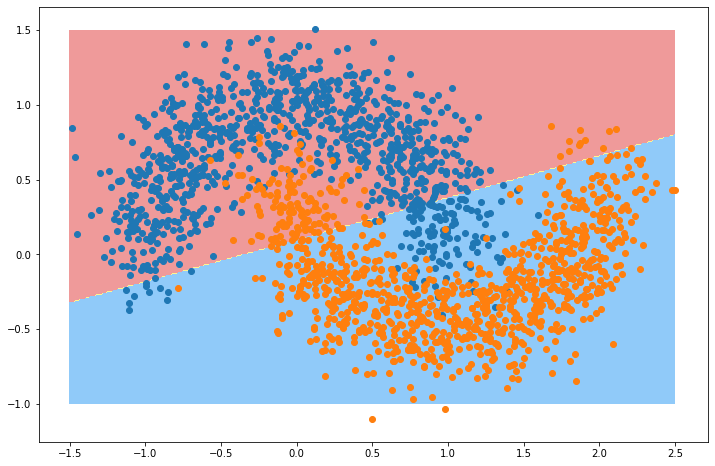

In [17]:
plt.figure(figsize=(12, 8))    
plot_decision_boundary(nn, [-1.5, 2.5, -1, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [11]:
y_predict = nn.predict(X_test)

In [12]:
y_predict[:10]

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [13]:
y_test[:10]

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [14]:
nn.accuracy(y_predict, y_test.flatten())

0.8916666666666667